<a href="https://colab.research.google.com/github/adriendod/Color_Classification/blob/master/Color_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
import json
from keras.models import Sequential,Model,load_model
from keras.optimizers import SGD
from keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.merge import Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import keras.backend as K
from tensorboardcolab import *


!nvidia-smi

Tue Apr 30 14:49:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   4707MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/Car_color_classification/data.zip" -d "/content"

In [0]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(224,224,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])
    
    return model
  
  

In [28]:
# model config
img_rows , img_cols = 224,224
num_classes = 9
batch_size = 64
nb_epoch = 20
data_directory = "/content/all"

#setup TensorBoard
tbc=TensorBoardColab()

# initialise model
model = color_net(num_classes)
print(model.summary())

Wait for 8 seconds...
TensorBoard link:
https://cecd2cbc.ngrok.io
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 54, 54, 48)   17472       input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 54, 54, 48)   17472       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 54, 54, 48)   192         conv2d_52[0][0]                  
___________________________________________

In [29]:
filepath = 'color_weights.hdf5'
checkpoint = TensorBoardColabCallback(tbc)
callbacks_list = [checkpoint]

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        validation_split=0.2)


training_set = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'training')

test_set = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'validation')



Found 24760 images belonging to 9 classes.
Found 6184 images belonging to 9 classes.


In [30]:
#Fitting model

history = model.fit_generator(
        training_set,
        steps_per_epoch=500,
        epochs=nb_epoch,
        validation_data=test_set,
        validation_steps=250,
        callbacks=callbacks_list)

model.save('/content/gdrive/My Drive/Car_color_classification/color_model.h5')
with open('/content/gdrive/My Drive/Car_color_classification/history.json', 'w') as f:
    json.dump(history.history, f)


Epoch 1/20
500/500 [==============================] - 718s 1s/step - loss: 1.1253 - acc: 0.6060 - val_loss: 0.7855 - val_acc: 0.7177
Epoch 2/20
500/500 [==============================] - 696s 1s/step - loss: 0.7646 - acc: 0.7308 - val_loss: 0.7048 - val_acc: 0.7463
Epoch 3/20
500/500 [==============================] - 699s 1s/step - loss: 0.6536 - acc: 0.7732 - val_loss: 1.0793 - val_acc: 0.6061
Epoch 4/20
500/500 [==============================] - 699s 1s/step - loss: 0.5833 - acc: 0.8009 - val_loss: 0.7007 - val_acc: 0.7377
Epoch 5/20
500/500 [==============================] - 696s 1s/step - loss: 0.5359 - acc: 0.8152 - val_loss: 0.5961 - val_acc: 0.7978
Epoch 6/20
500/500 [==============================] - 701s 1s/step - loss: 0.4904 - acc: 0.8322 - val_loss: 0.7031 - val_acc: 0.7438
Epoch 7/20
500/500 [==============================] - 701s 1s/step - loss: 0.4743 - acc: 0.8383 - val_loss: 0.5380 - val_acc: 0.8225
Epoch 8/20
500/500 [==============================] - 698s 1s/step - 

NameError: ignored

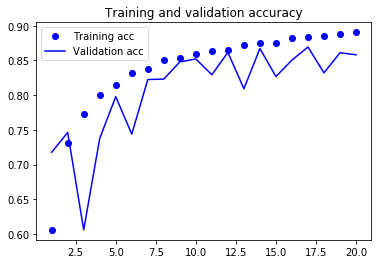

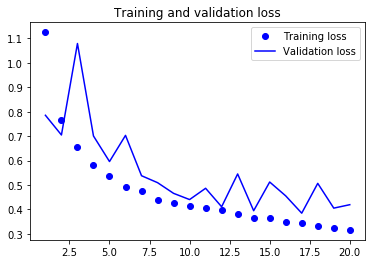

In [32]:
#plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [41]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_set, 250)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['0-black', '1-grey-other', '2-grey-light', '3-white', '4-yellow', '5-green', '6-blue', '7-red', '8-notACar']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix


ValueError: ignored

In [39]:
#print(training_set.class_indices)
print(test_set.classes)


[0 0 0 ... 8 8 8]


In [0]:
!cd

model = load_model("/gdrive/My Drive/Car_color_classification/color_model2.h5")
classes = training_set.class_indices
colors = ["black", "blue", "cyan", "green", "grey-light", "grey-other", "notACar", "red", "white", "yellow"]
df = pd.DataFrame(columns=colors)

def model_test(color):
    path = "/content/data/" + color + "/"
    i = 0
    for img in os.listdir(path):
      if img.lower().endswith(('.png', '.jpg', '.jpeg')) : 
        img = image.load_img(path + img, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img/255
        img = img.reshape(1,224,224,3)
        prediction = model.predict(img)
        prediction = prediction.argmax(axis=-1)
        df.loc[i,color] = prediction[0]
        i += 1

for color in colors :
  model_test(color)
  

      

In [0]:
df.head()

,black,blue,cyan,green,grey-light,grey-other,notACar,red,white,yellow
0,0,1,2,3,4,5,6,7,8,9
1,0,1,2,3,8,0,6,7,8,8
2,0,1,2,0,4,5,6,7,8,9
3,0,0,2,3,4,5,6,7,8,9
4,0,5,2,3,4,0,6,7,8,9


In [0]:
i = 0
for color in colors:
  guesses = df[colors].eq(i).sum()
  total = df[color].count()
  pourcentage = guesses / total * 100
  print(str(color + ": " + str(pourcentage)))
  i += 1
  
  

In [0]:
model.evaluate_generator(test_set, steps = 20, verbose = 0)

StopIteration: ignored